# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the longest (1949-present) and most complete (more than 50,000 sampling stations) time series of oceanographic and larval fish data in the world. It includes abundance data on the larvae of over 250 species of fish; larval length frequency data and egg abundance data on key commercial species; and oceanographic and plankton data. The physical, chemical, and biological data collected at regular time and space intervals quickly became valuable for documenting climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific-warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern & central California, collecting a suite of hydrographic and biological data on station and underway. Data collected at depths down to 500 m include: temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could $\textcolor{red}{\text{predict the temperature of the water based on the salinity and the depth}}$, and possibly other available features.

In [1]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

The Bottle Dataset and the Cast Dataset from the CalCOFI (California Cooperative Oceanic Fisheries Investigations) database have distinct characteristics and purposes, which are reflected in their field descriptions.

1. Bottle Dataset:

The Bottle Dataset focuses on detailed measurements taken from specific water samples (bottles) collected at various depths in the ocean. Key features of this dataset include​​:

$\underline{\text{Detailed Measurements}}$: Parameters such as temperature (T_degC), salinity (Salnty), dissolved oxygen (O2ml_L), nutrients like phosphate (PO4µM), nitrate (NO3µM), and silicate (SiO3µM), chlorophyll (ChlorA), and phaeophytin (Phaeop) concentrations.

$\underline{\text{Quality Codes}}$: Many fields have associated quality codes (e.g., T_qual for temperature quality) to indicate the reliability of the data.

$\underline{\text{Sample-Specific Data}}$: Data like bottle number (BtlNum), cast count (Cst_Cnt), and bottle count (Btl_Cnt) which indicate the specific sample and its relation to the overall survey.

$\underline{\text{Carbon Measurements}}$: Data on carbon assimilation in milligrams per cubic meter (e.g., C14As1, C14As2) and related quality codes.

$\underline{\text{Reported Parameters}}$: There are 'reported' versions of many parameters (e.g., R_TEMP, R_SALINITY), possibly indicating processed or validated measurements.


2. Cast Dataset:

The Cast Dataset, on the other hand, is more about the overall characteristics of each oceanographic cast, which is a broader set of measurements taken at a particular location and time. This dataset includes​​:

$\underline{\text{Cruise and Station Information}}$: Data such as cruise ID (Cruise_ID), station ID (Sta_ID), and quarter of the year (Quarter).

$\underline{\text{Geographic and Temporal Data}}$: Information like latitude (Lat_Dec), longitude (Lon_Dec), date (Date), and time (Time) of the cast.

$\underline{\text{Environmental Observations}}$: Includes wave direction (Wave_Dir), wave height (Wave_Ht), wind speed (Wind_Spd), atmospheric pressure (Barometer), and air temperature (Dry_T, Wet_T).

$\underline{\text{Chlorophyll and Productivity}}$: Integrated chlorophyll (IntChl) and carbon productivity (IntC14) measurements.

$\underline{\text{Visibility and Weather Data}}$: Parameters like cloud type (Cloud_Typ), amount (Cloud_Amt), visibility (Visibility), and water color (ForeIU).

3. Key Differences between Bottle vs Cast Datasets

$\underline{\text{Scope of Data}}$: The Bottle Dataset provides specific, detailed chemical and physical measurements from individual water samples, while the Cast Dataset offers broader environmental and oceanographic data from each cast.

$\underline{\text{Detail Level}}$: Bottle data is more granular and focused on the contents of the water sample, whereas cast data encompasses wider environmental conditions and situational data.

$\underline{\text{Purpose}}$: The Bottle Dataset is likely used for detailed chemical and biological analysis of water samples, whereas the Cast 

Dataset could be more relevant for understanding the overall conditions of an oceanographic expedition or survey.
These datasets, when combined, offer a comprehensive view of oceanographic conditions, ranging from micro-level chemical compositions to macro-level environmental and oceanographic data.

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [2]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.3.x

1.3.0


### Utility Functions

In [3]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [4]:
# Change to your data folder
DATA = Path("C:/Users/pmoll/Desktop/Master/Semester 2/ML Hands-on Scikit Learn/TP_3_Regression")
assert DATA.exists()

In [5]:
bottle_raw_df = pd.read_csv(DATA / "bottle.csv", low_memory=False)

In [6]:
#bottle_raw_df

In [7]:
bottle_descriptions_df = pd.read_csv(DATA / "Bottle Field Descriptions.csv", encoding="cp1252",).drop(columns=["Unnamed: 3"])

In [8]:
bottle_descriptions_df

,Field Name,Units,Description
0,Cst_Cnt,n.a.,"Cast Count - All CalCOFI casts ever conducted,..."
1,Btl_Cnt,n.a.,Bottle Count - All CalCOFI bottles ever sample...
2,Sta_ID,n.a.,Line and Station [Line] [Station]
3,Depth_ID,n.a.,Uses the Cast_ID prefix ([Century]-[Year][Mont...
4,Depthm,meters,Bottle depth in meters
...,...,...,...
57,TA1,micromoles per kilogram,Total Alkalinity micromoles per kilogram solution
58,TA2,micromoles per kilogram,Total Alkalinity micromoles per kilogram solut...
59,pH1,pH scale,pH (the degree of acidity/alkalinity of a solu...
60,pH2,pH scale,pH (the degree of acidity/alkalinity of a solu...


We would like to know how we could $\textcolor{red}{\text{predict the temperature of the water based on the salinity and the depth}}$, and possibly other available features.

In [9]:
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,1,0,10.500,33.4400,NaN,25.64900
1,1,8,10.460,33.4400,NaN,25.65600
2,1,10,10.460,33.4370,NaN,25.65400
3,1,19,10.450,33.4200,NaN,25.64300
4,1,20,10.450,33.4210,NaN,25.64300
...,...,...,...,...,...,...
864858,34404,0,18.744,33.4083,5.805,23.87055
864859,34404,2,18.744,33.4083,5.805,23.87072
864860,34404,5,18.692,33.4150,5.796,23.88911
864861,34404,10,18.161,33.4062,5.816,24.01426


In [10]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  864863 non-null  int64  
 1   Depthm   864863 non-null  int64  
 2   T_degC   853900 non-null  float64
 3   Salnty   817509 non-null  float64
 4   O2ml_L   696201 non-null  float64
 5   STheta   812174 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 39.6 MB


#### Cleaning

Remove the NaN values

To remove rows/columns that have no use due to incorrect, not wanted or absent (NaN) content, we can proceed in different ways:

Let's delete rows where age is greater than 30 from a dataframe (df) that you have already in memory.

A. $\underline{\text{Removing not wanted data}}:$

1. Using boolean indexing:

$$ df_{new} = \text{df[df['age'] <= 30]} $$

2. Using drop():

$$ df_{new} = \text{df.drop(df[df['age'] > 30].index)} $$

3. Using query():

$$ df_{new} = \text{df.query('age <= 30')} $$

4. Using loc:

$$ df_{new} = \text{df.loc[df['age'] <= 30]} $$

B. $\underline{\text{Removing Nan values}}:$ If a row has a NaN value in just one column, the complete row disappears.

1. $$ df_{new} = \text{df.dropna()} $$

In [11]:
bottle_df = bottle_df.dropna()
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
2160,71,0,10.300,33.0300,5.900,25.36400
2161,71,6,18.460,32.9200,6.020,23.56800
2162,71,10,10.290,32.9510,6.040,25.30400
2163,71,15,10.290,32.9900,6.060,25.33500
2164,71,20,10.330,33.0050,6.040,25.33900
...,...,...,...,...,...,...
864858,34404,0,18.744,33.4083,5.805,23.87055
864859,34404,2,18.744,33.4083,5.805,23.87072
864860,34404,5,18.692,33.4150,5.796,23.88911
864861,34404,10,18.161,33.4062,5.816,24.01426


### Data Analysis

To calculate the correlation between two variables, such as height and weight, you can use a statistical measure called the correlation coefficient. The most common correlation coefficient used is the Pearson correlation coefficient (also known as Pearson's r), but there are other correlation coefficients like Spearman's rank correlation coefficient and Kendall's tau.

Here's how you can calculate the Pearson correlation coefficient between height and weight:

1. Gather your data: Collect data on height and weight for the individuals or objects you want to analyze.

2. Calculate the means: Calculate the mean (average) of both the height and weight values.

3. Calculate the covariance: Compute the covariance between the height and weight values. The formula for covariance is:

$$ Cov(X, Y) = \sum_{i=1}^{n} \frac{(X_{i} - \bar{X}) \cdot (Y_{i} - \bar{Y})}{n - 1} $$

Where:
   $$ \text{Cov(X, Y) is the covariance between X and Y} $$
   $$ X_{i} \text{ and } Y_{i} \text{ are individual data points of height and weight} $$
   $$ \bar{X} \text{ is the mean of height} $$
   $$ \bar{Y} \text{ is the mean of weight} $$
   $$ n \text{ is the number of data points} $$

4. Calculate the standard deviations: Compute the standard deviation of both height and weight. The formula for standard deviation is:

   $$ SD(X) = \sqrt{\sum_{i=1}^{n} \frac{(X_{i} - \bar{X})^2}{n - 1}} $$
   $$ SD(Y) = \sqrt{\sum_{i=1}^{n} \frac{(Y_{i} - \bar{Y})^2}{n - 1}} $$

   Where:
   $$ \text{SD(X) is the standard deviation of height} $$
   $$ \text{SD(Y) is the standard deviation of weight} $$
   $$ X_{i} \text{ and } Y_{i} \text{ are individual data points of height and weight} $$
   $$ \bar{X} \text{ is the mean of height} $$
   $$ \bar{Y} \text{ is the mean of weight} $$
   $$ n \text{ is the number of data points} $$

5. Calculate the Pearson correlation coefficient (r): 

Finally, you can calculate the Pearson correlation coefficient using the following formula:

$$ r = \frac{Cov(X, Y)}{SD(X) \cdot SD(Y)} $$

6. Interpretation of values:

The resulting value of r will be between -1 and 1. 
- If r is close to 1, it indicates a strong positive linear correlation (as one variable increases, the other tends to increase).
- If r is close to -1, it indicates a strong negative linear correlation (as one variable increases, the other tends to decrease and viceversa).
- If r is close to 0, it suggests a weak or no linear correlation between the two variables.

#### Plot Correlation Matrix with Seaborn

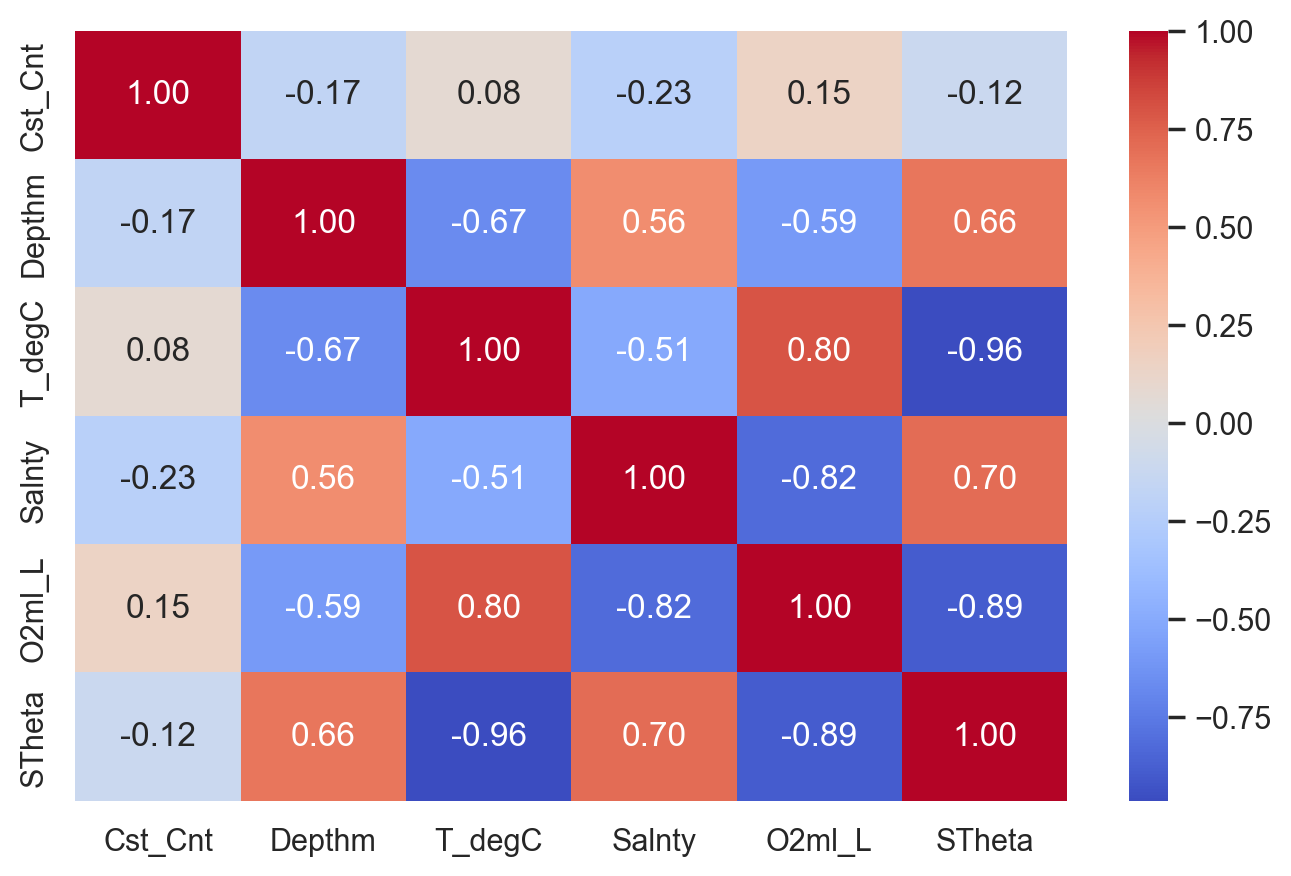

In [12]:
# 
correlation_matrix = bottle_df.corr()

# Plot the heatmap
plt.figure(figsize=(8,5))  # Size is optional and can be adjusted
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.show()

Let's remember the descriptions of the studied variables:

1. $Cst_{Cnt}$ Auto-numbered cast count (No idea)

2. $Depthm$: Depth in meters.

3. $T_{degC}$: Temperature of water in degrees Celcius.

4. $Salnty$: Salinity of water.

5. $02ml_{L}$: Milimeters of dissolved oxygen per liter of seawater.

6. $S_{Theta}$: Potential Density of water.



#### Correlation Plots

Select from the correlation matrix the 4 features that are involved in the most correlated pairs and plot their relationship.
I understand that it doesn't matter it they are negatively or positively correlated, the higher the correlation, the better.

   Variable1 Variable2  Correlation  AbsCorrelation
32    STheta    T_degC    -0.964140        0.964140
34    STheta    O2ml_L    -0.889568        0.889568
22    Salnty    O2ml_L    -0.824384        0.824384
16    T_degC    O2ml_L     0.795007        0.795007


c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



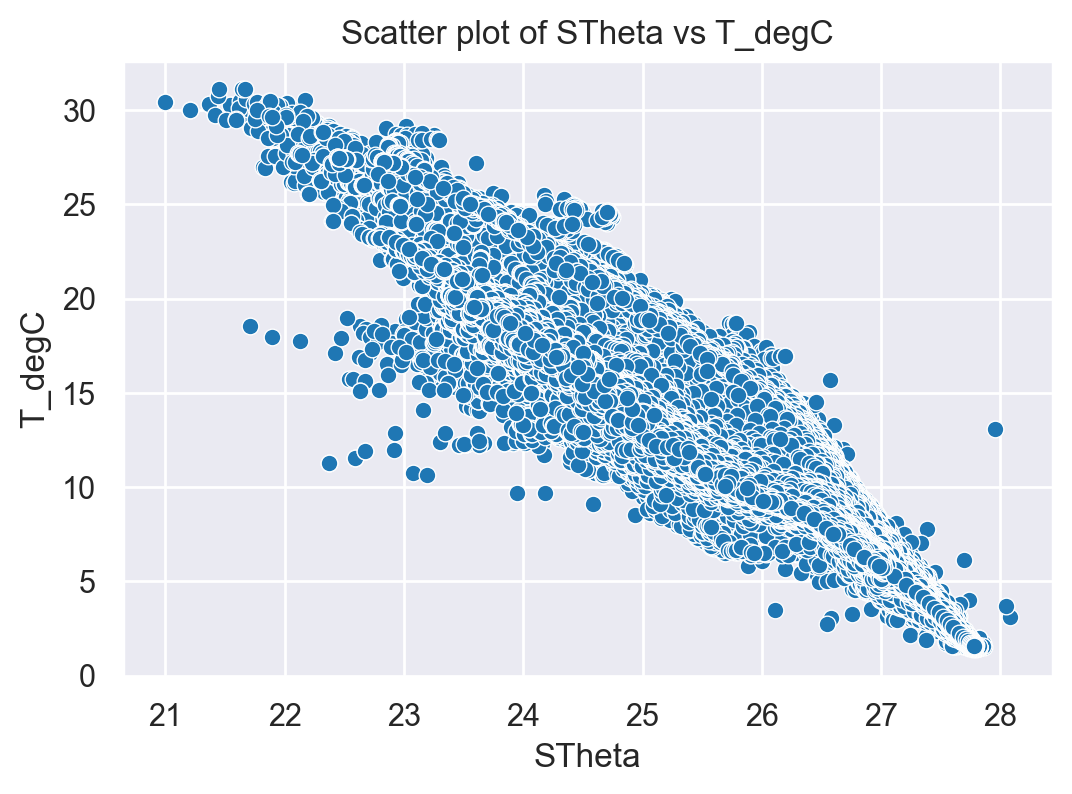

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



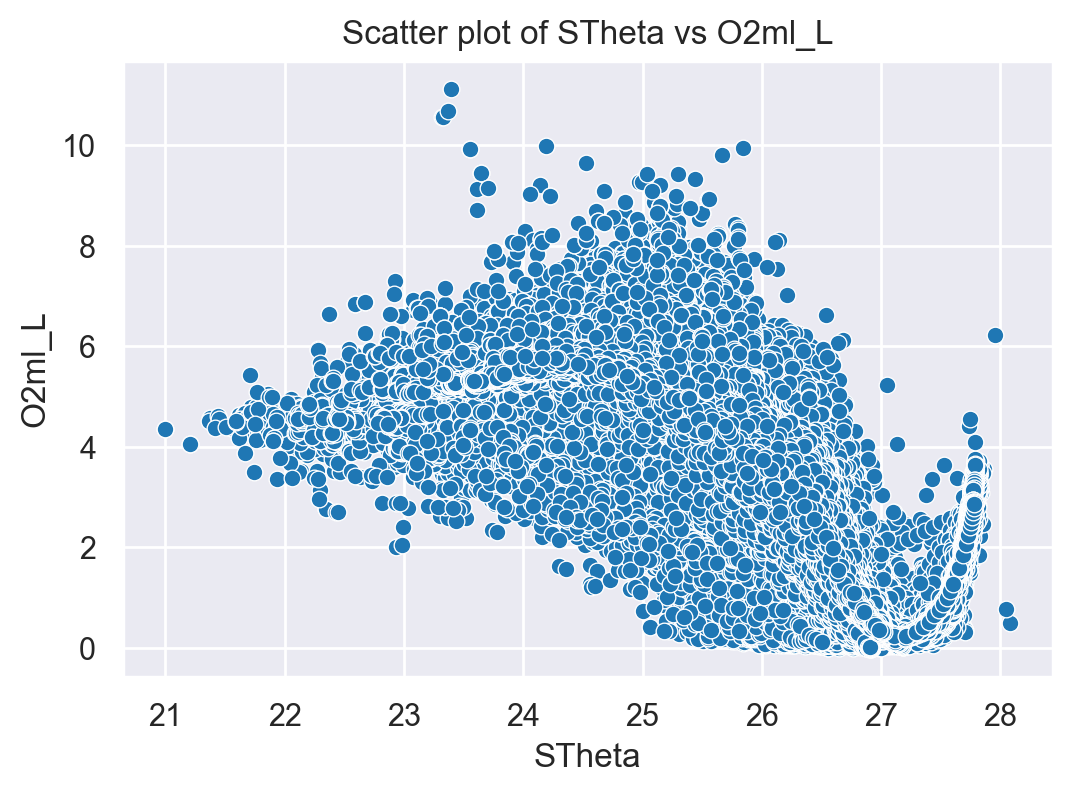

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



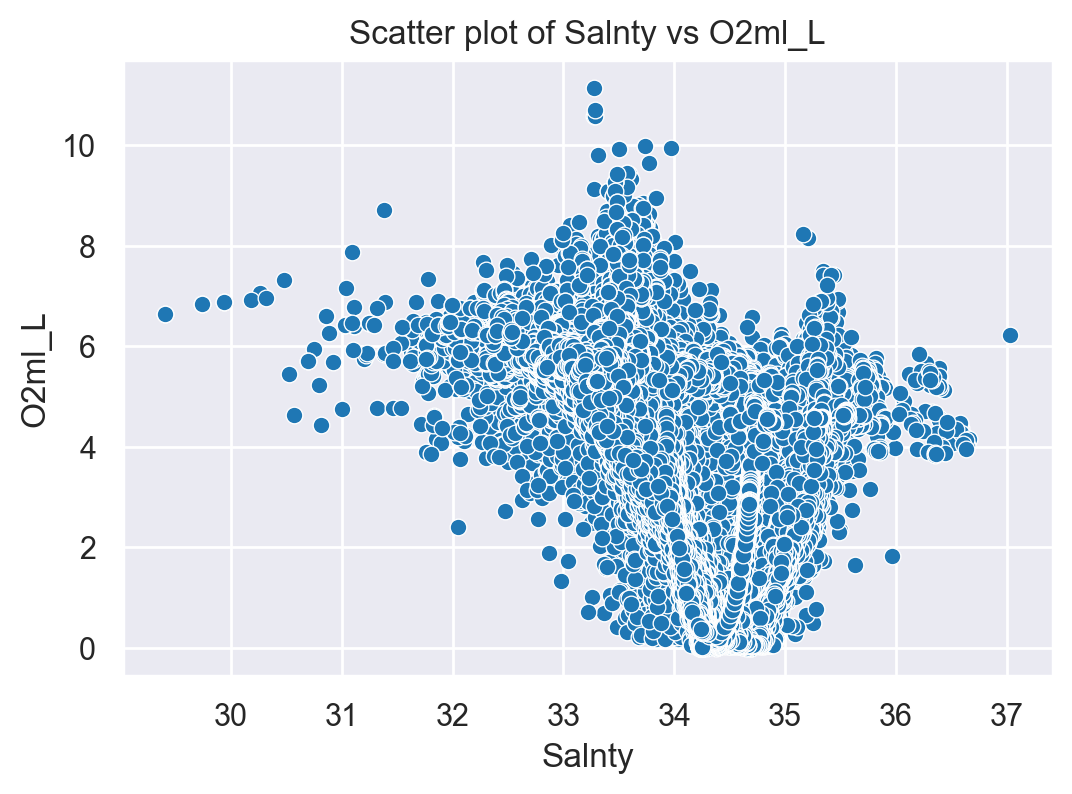

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



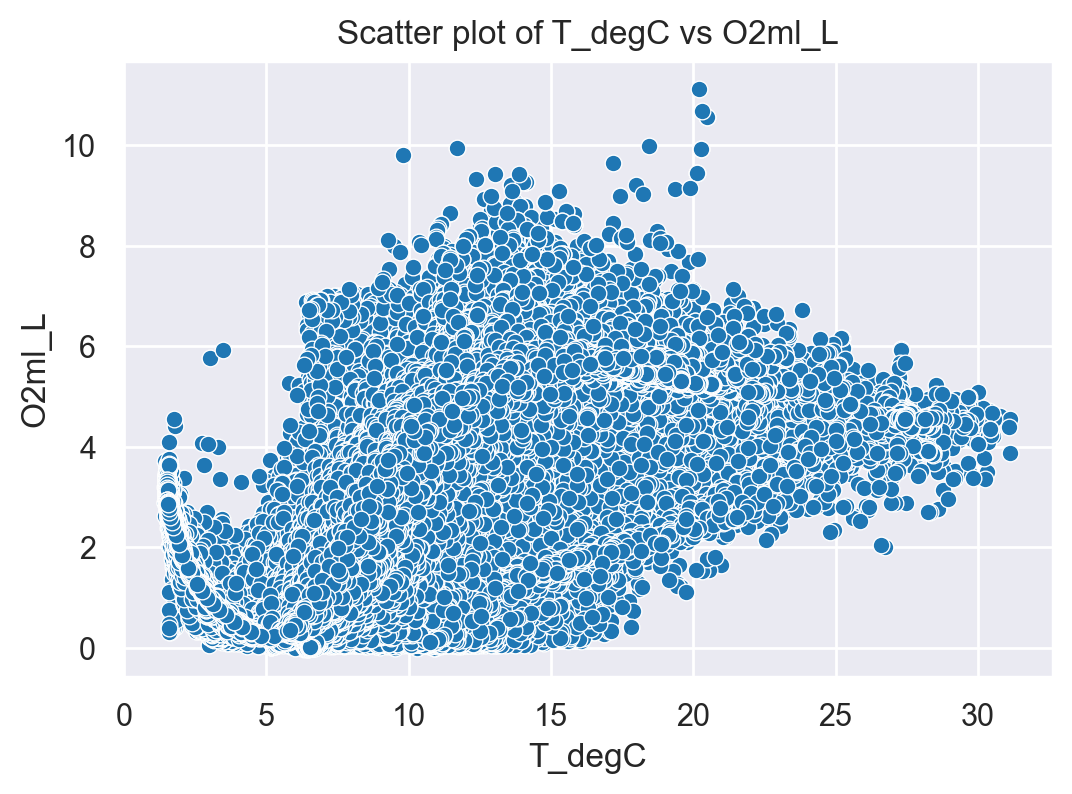

In [13]:
# We create a DataFrame from the correlation matrix, stack it, and reset the index
corr_pairs = correlation_matrix.unstack().reset_index()

# Now, we can access to the pairs via order (numbers), before we had to write to access with column titles
#print(corr_pairs)
#print(corr_pairs[[0,0]])

# We rename the columns where the variables names are stored to simplify
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']


# Remove self correlation (obviously the variable is correlated with itself)
corr_pairs = corr_pairs[corr_pairs['Variable1'] != corr_pairs['Variable2']]
#print(corr_pairs)

# We add a new column with the absolute correlation value (it will be easier to compare this way)
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()

# Sort by absolute value of correlation in descending order
sorted_pairs = corr_pairs.sort_values('AbsCorrelation', ascending=False)
#print(sorted_pairs)


# We drop duplicates (we will have things like (Height, Weight) = 0.9 and (Weight, Height) = 0.9, it's basically the same so we drop it)
no_duplicates = sorted_pairs.drop_duplicates(subset=['AbsCorrelation'])


# Take the top 4 unique pairs
top_pairs = no_duplicates.head(4)
print(top_pairs)


# Now, plot the top 4 most correlated pairs
for i, row in top_pairs.iterrows():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=bottle_df, x=row['Variable1'], y=row['Variable2'], ax=ax)
    ax.set_title(f"Scatter plot of {row['Variable1']} vs {row['Variable2']}")
    plt.show()


#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



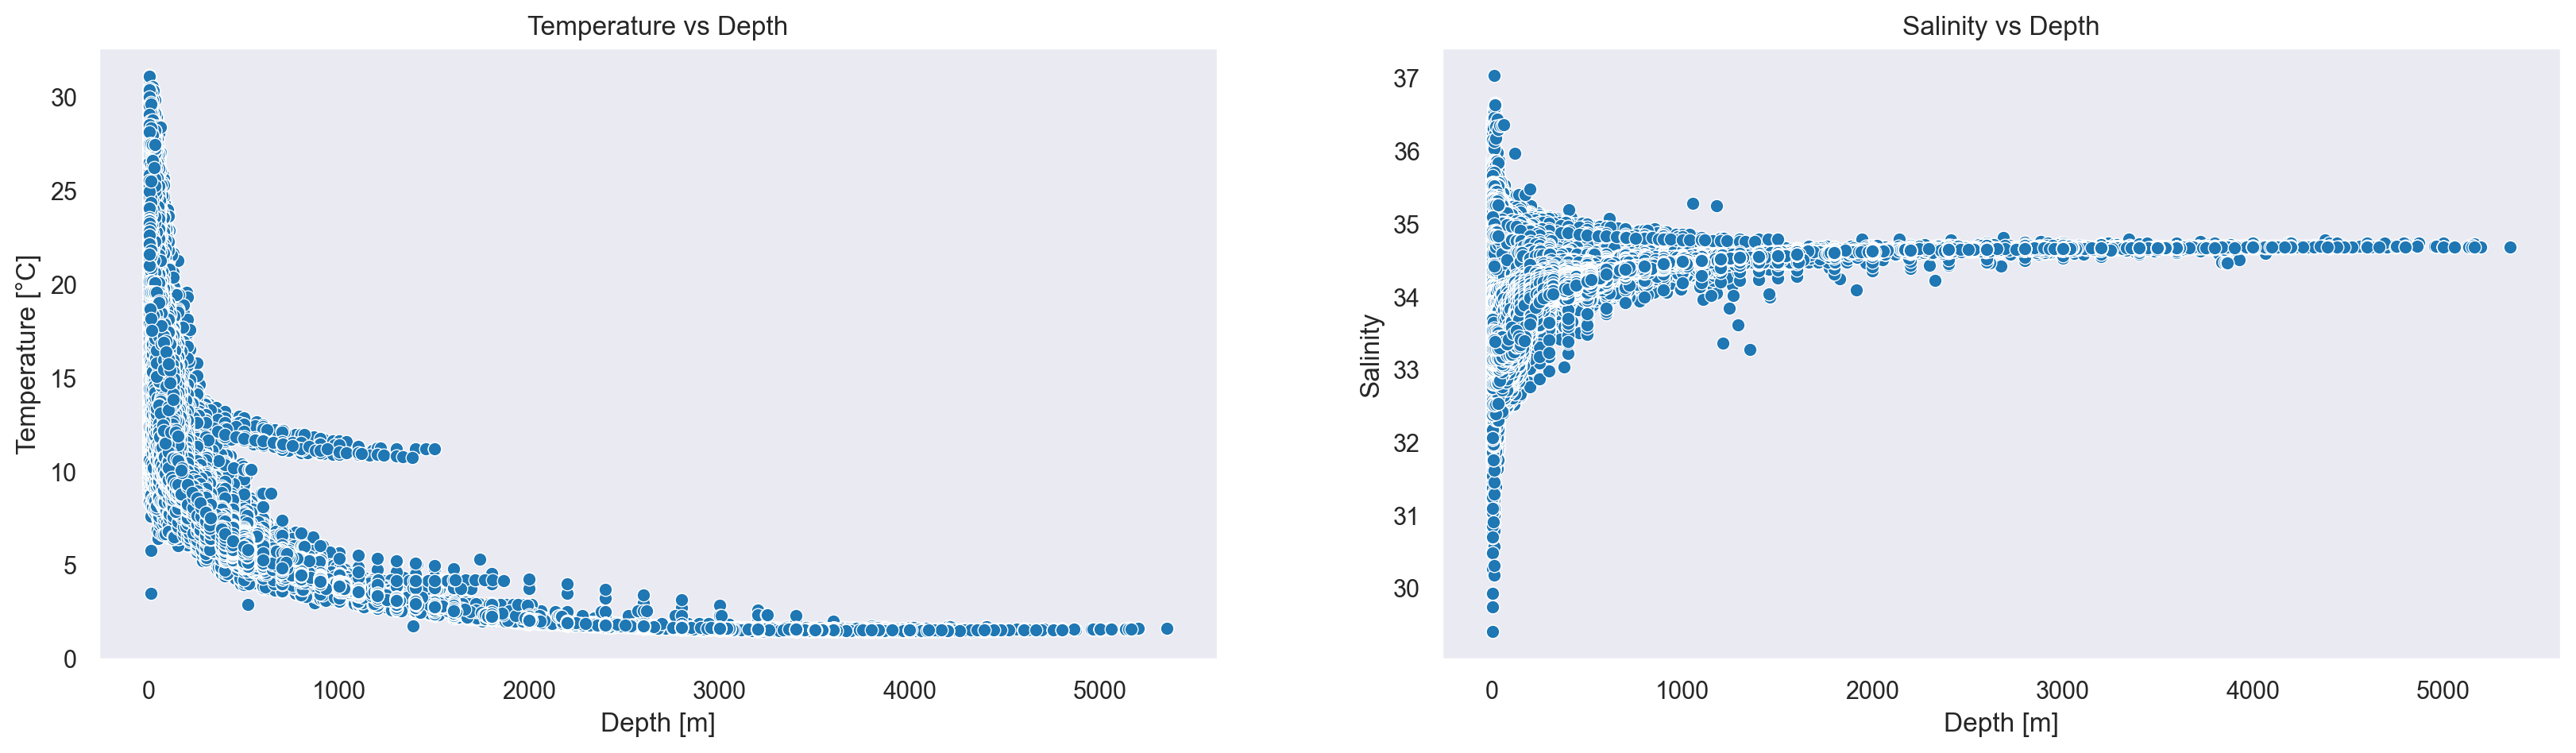

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot some points in the upper part of the image show a different trend from the rest of the graph. It's an unexpected behavior, because, for instance, at around 1000 m depth the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html)

- In the second plot we can notice that the points converge asymptotically from both high and low salinity values. It means that in some areas of the ocean the salinity increases with the depth, vice versa in other areas it decreases. 

If we isolate datapoints with salinity values in the range above the sality values in the deepest ocean area, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [15]:
# Let's extract all the values where we have recorded the maximum depth
max_depth = bottle_df.loc[bottle_df.Depthm.idxmax()]
#print("At maximum depth we have recorded the following values:\n",max_depth, "\n")


# Now we extract the salinity in the max depth
max_depth_salnty = max_depth.Salnty
print("Maximum recorded Salinity:", max_depth_salnty)


# Margin to stay on the upper side of the asymptote
max_depth_salnty += 0.1
pprint_var(max_depth_salnty=max_depth_salnty)

# We create another dataframe in which we select only the rows having higher salinity levels than the salinity recorded at maximum depth
bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df


Maximum recorded Salinity: 34.68
max_depth_salnty = 34.78


,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
9204,305,1180,3.10,35.250,0.49,28.083
40328,1303,854,4.01,34.930,1.85,27.736
41497,1339,415,7.80,35.090,0.28,27.381
55857,1809,2142,1.98,34.790,1.85,27.817
55862,1809,2688,1.73,34.810,2.47,27.855
...,...,...,...,...,...,...
479617,19189,11,27.49,34.839,4.62,22.442
479618,19189,20,27.47,34.838,4.59,22.449
479619,19189,30,27.45,34.837,4.55,22.455
479620,19189,31,27.45,34.837,4.55,22.455


c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Py

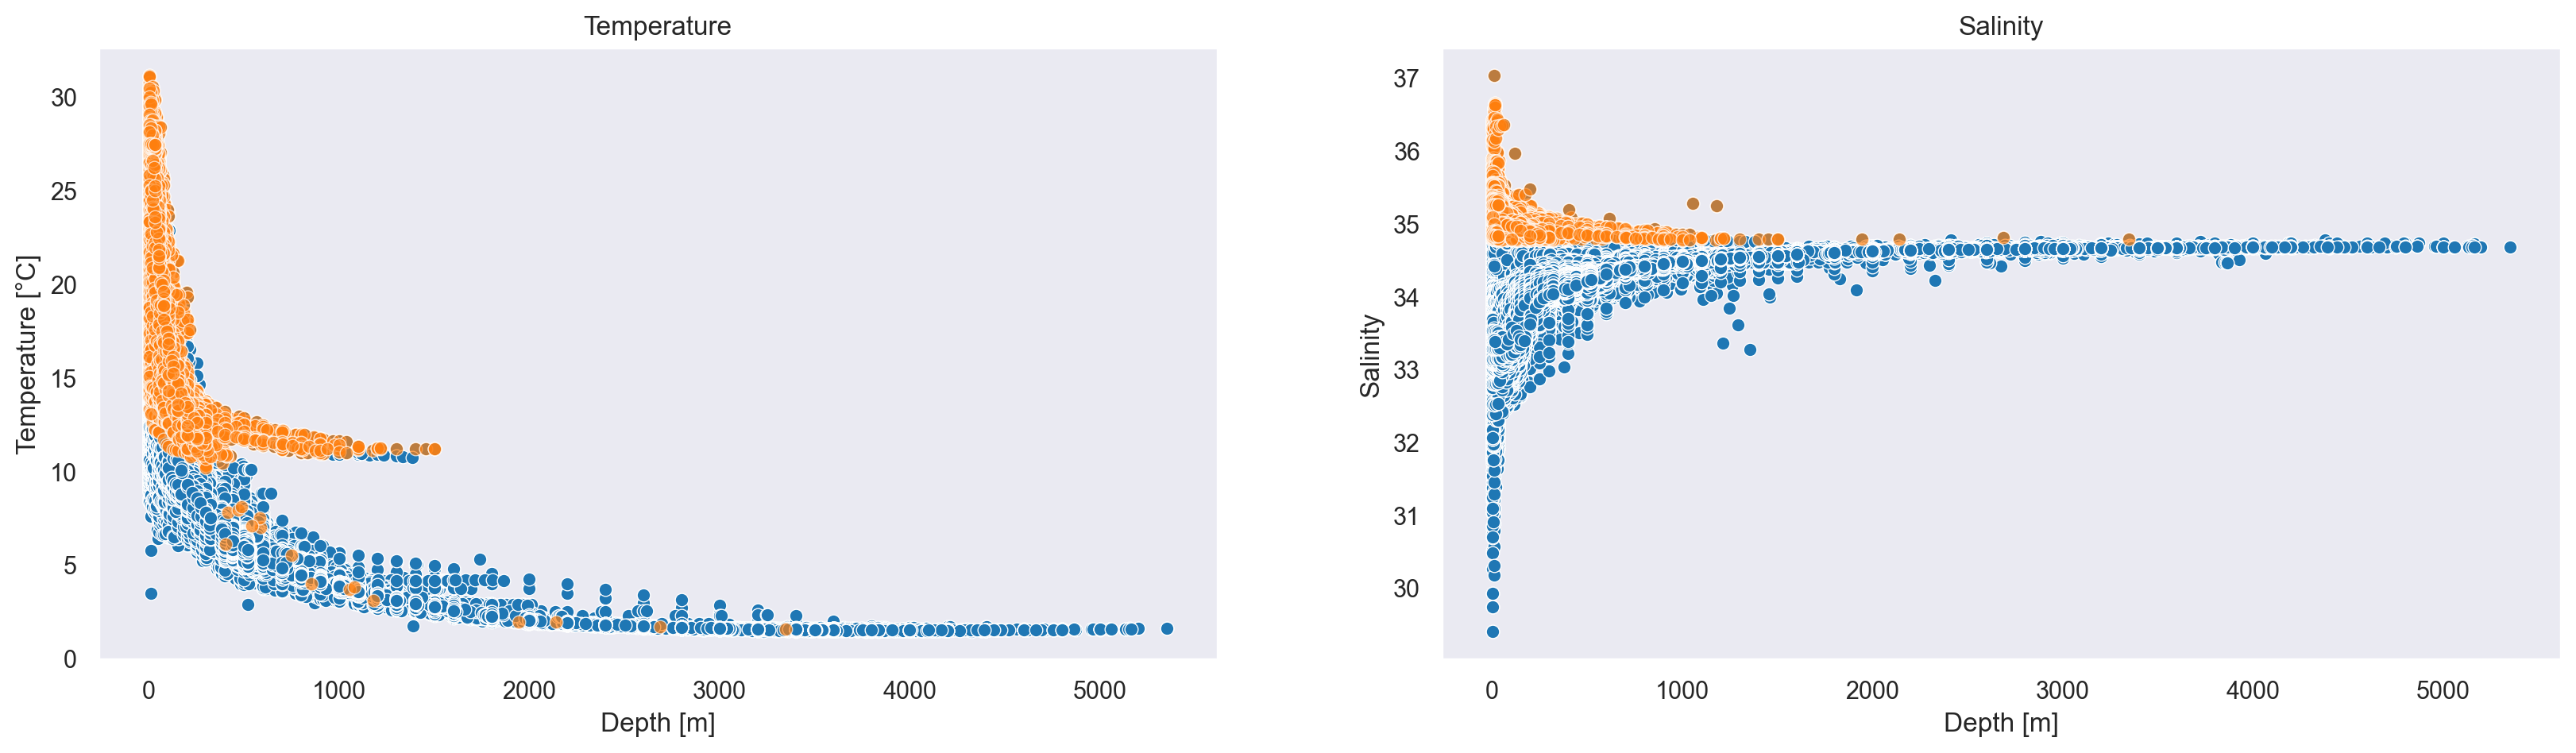

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

$\underline{\text{Definition of the metrics}}$:

1. RMSE (Root Mean Square Error)

$$ RMSE ={\sqrt {{\frac{1}{n}}\sum _{i=1}^{n}(X_{i}-\hat{X_{i}})^{2}}} $$

where 
$n$ is the number of observations, $X_{i}$ is the actual observed value and $\hat{X_{i}}$ is the predicted value from the model.

$\underline{Interpretation}:$

- An RMSE of 0 indicates that the model makes perfect predictions with no errors, which is typically not possible with real-world data.

- The RMSE is always non-negative, and a lower value indicates a better fit. The closer the RMSE is to 0, the better the model is at predicting the observed outcomes.

2. R2-Score

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^{n} (X_i - \hat{X}_i)^2}{\sum_{i=1}^{n} (X_{i} - \bar{X})^2}$$

The terms $SS_{res}$(Sum of Squares of Residuals) and $ SS_{tot}$(Total Sum of Squarees) are defined as follows:

$$ SS_{res} = \sum_{i=1}^{n} (X_i - \hat{X}_i)^2 $$

$$ SS_{tot} = \sum_{i=1}^{n} (X_{i} - \bar{X})^2 $$

Where $\bar{X}$ denotes the mean of X.

$\underline{Interpretation}:$

- An R² score of 1 indicates that the regression predictions perfectly fit the data. 
- An R² score of 0 indicates that the model explains none of the variability of the response data around its mean.
- Negative values of R² may occur when the model fits the data worse than a horizontal hyperplane at the mean of the dependent variable.


(529014, 1)


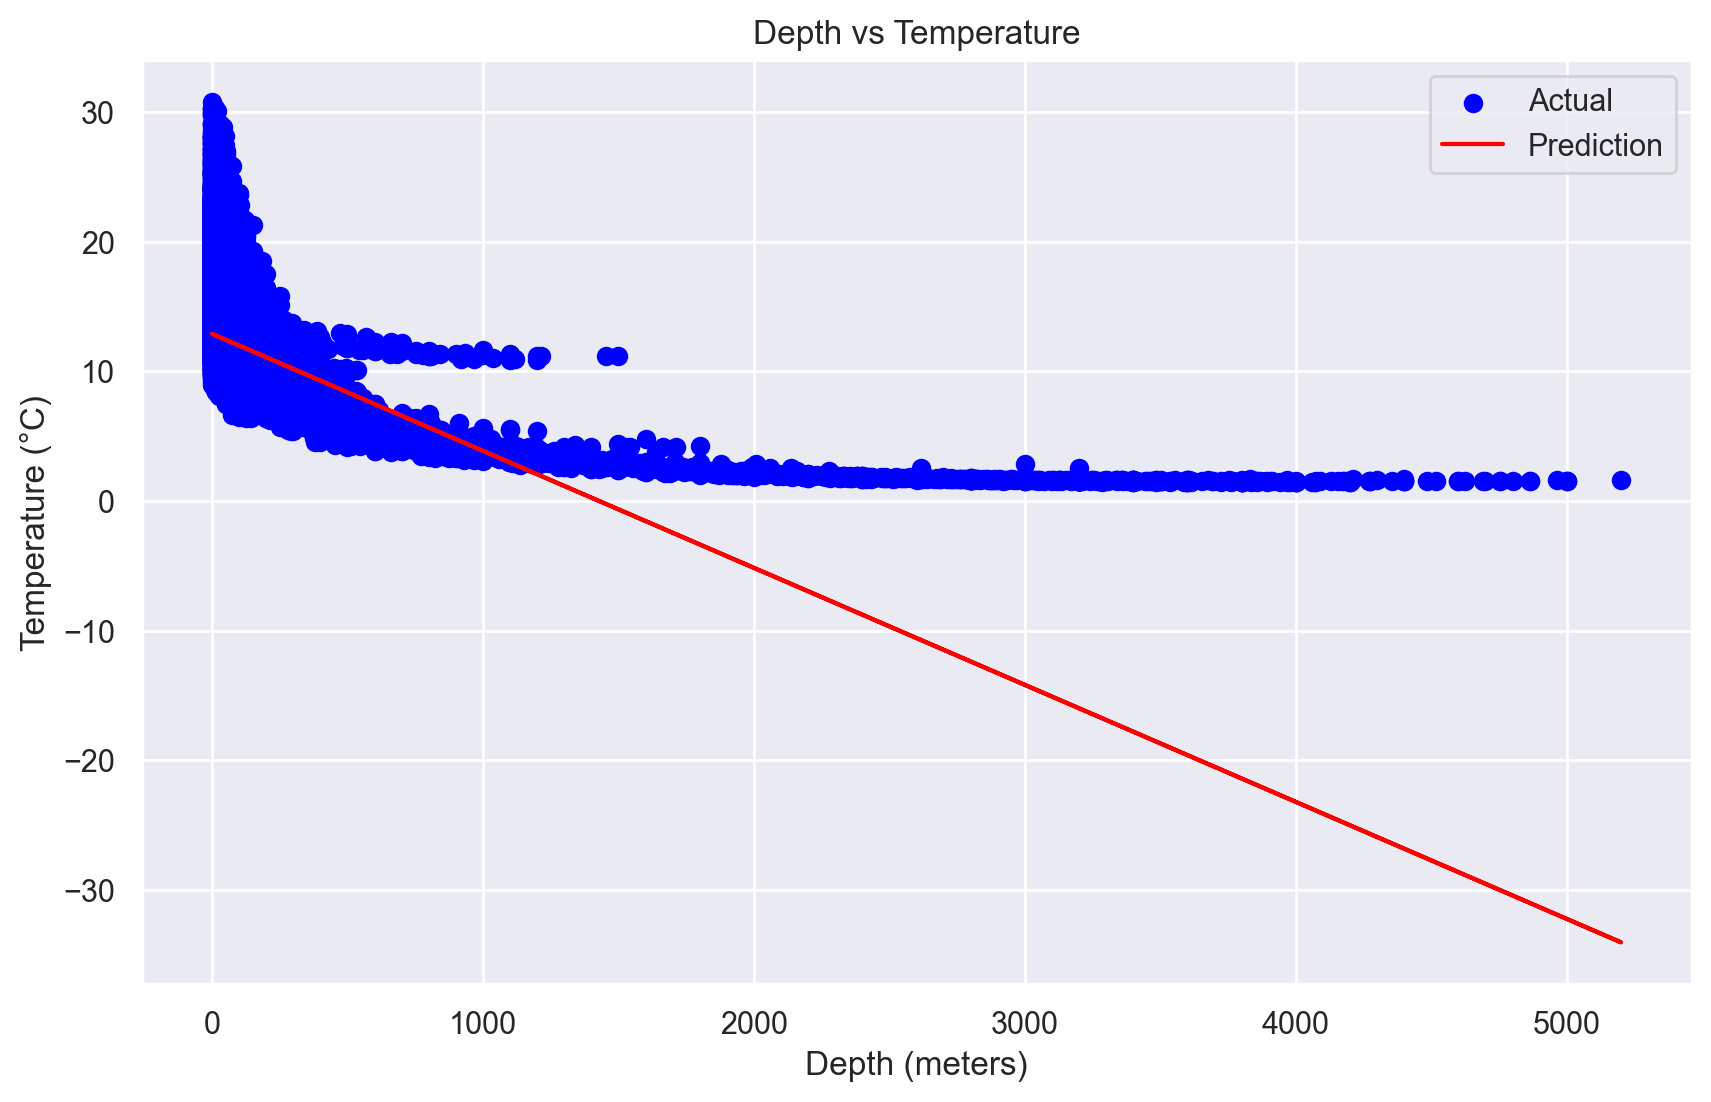

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Select the features (Depthm) and the target (T_degC)
X = bottle_df[['Depthm']]
y = bottle_df['T_degC']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

# Create and train the model
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, y_train)

# Predict the temperature for the test set
y_pred = model_LinearRegression.predict(X_test)

# Evaluate the model with the chosen metrics
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred))
R2_score = r2_score(y_test, y_pred)

# Output the RMSE and R^2 score
RMSE_score, R2_score

# Plotting the test data and the prediction line
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Prediction')
plt.title('Depth vs Temperature')
plt.xlabel('Depth (meters)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

The scatter plot with the linear regression prediction line suggests a strong relationship between depth and temperature, that is, as depth increases, temperature generally decreases. However, the relationship appears to be nonlinear, especially at shallower depths where temperature changes more rapidly with depth.

The linear regression line does not capture this nonlinearity, as indicated by the residuals (the vertical gaps between the actual data points and the red prediction line). This suggests that the linear model may not be the best fit for this data.
Clearly, not the best model, so let's try with a Polynomial Regression.

### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

When you include the $\textcolor{green}{include\_ bias=False}$ parameter in PolynomialFeatures, you are telling the function not to add a column of ones to the output feature matrix. By default, PolynomialFeatures includes a bias (also known as the intercept term) in the form of a column of ones in the transformed feature matrix, which corresponds to the coefficient $\theta_{0}$ in a polynomial regression model:

$$ h_{\theta(x)} = \theta_{0} + \theta_{1}\cdot x + \theta_{2}\cdot x^2 + ... + \theta_{n}\cdot x^n $$

Here, the bias term is $\theta_0$, which is the value of the prediction when all features are zero (it's like an offset from the origin).

If you set $\textcolor{green}{include\_ bias=False}$, the feature matrix generated by PolynomialFeatures will not include this column of ones, and it assumes that you are either handling the bias term yourself or you do not want to include it for some reason. In other words, your polynomial features will start directly with the term corresponding to $\theta_{1}$ and will not have a constant term.

However, if you are using PolynomialFeatures followed by LinearRegression, setting $\textcolor{green}{include\_ bias=False}$ is typically fine because $\underline{\text{LinearRegression includes the calculation of the intercept term by default}}$ (unless you explicitly set fit_intercept=False when creating the LinearRegression object).

In summary, using $\textcolor{green}{include\_ bias=False}$ with PolynomialFeatures followed by a typical regression algorithm like LinearRegression which calculates its own intercept, will not change your model's predictions. This is because the regression algorithm will still fit an intercept (or bias) term, even if the polynomial feature matrix doesn't include a column for it.

If you do not include it in PolynomialFeatures and don't specify in LinearRegression $fit\_ intercept=False$, then you will calculate 2 times the bias term and the prediction would be wrong.

(529014, 1) (132254, 1)
RMSE_Polynomial_Regression: 2.0833822558657675
R^2_Polynomial_Regression: 0.7563416881062934


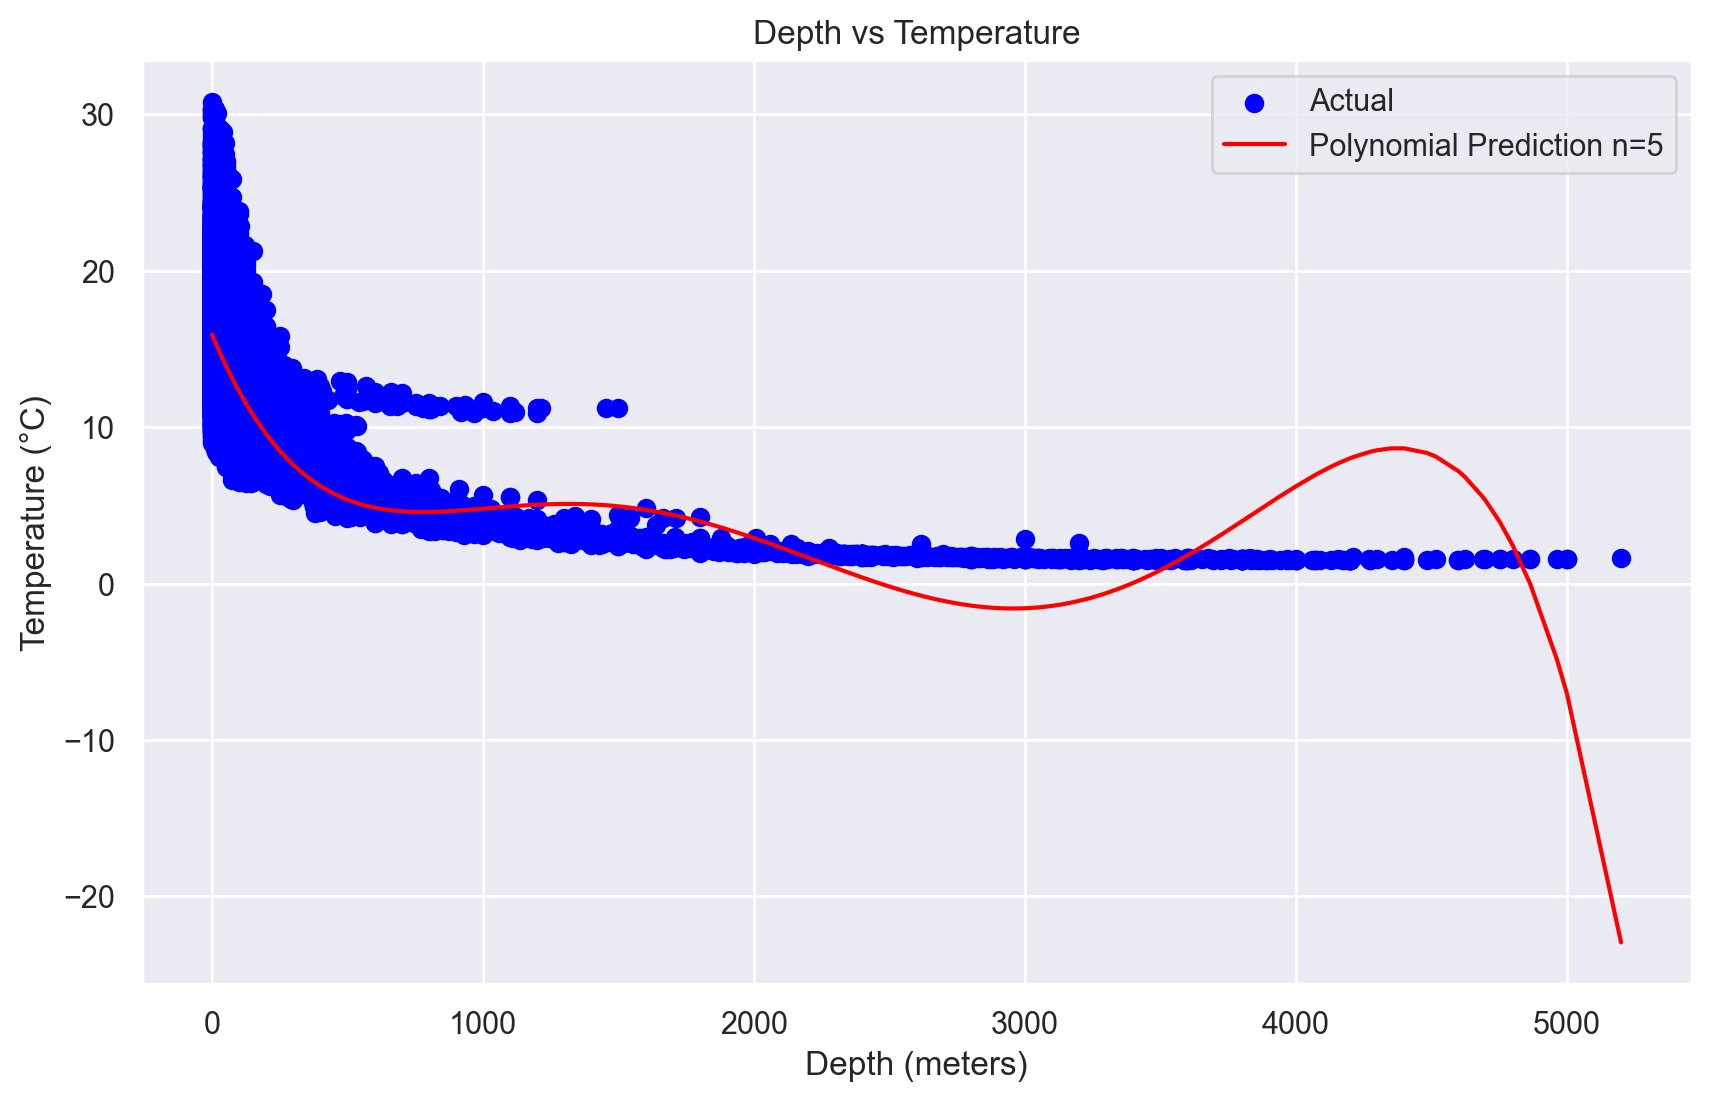

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Select the features (Depthm) and the target (T_degC)
X_poly = bottle_df[['Depthm']]
y_poly = bottle_df['T_degC']

# Split the data into training and test sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# Create polynomial features up to degree 5
polynomial_features = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly_transformed = polynomial_features.fit_transform(X_train_poly)
X_test_poly_transformed = polynomial_features.transform(X_test_poly)
print(X_train_poly.shape, X_test_poly.shape)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train_poly_transformed, y_train_poly)

# Predict on the test set
y_pred_poly = model.predict(X_test_poly_transformed)

# Calculate RMSE and R2 score for evaluation
RMSE_score_poly = np.sqrt(mean_squared_error(y_test_poly, y_pred_poly))
R2_score_poly = r2_score(y_test_poly, y_pred_poly)

# Print the evaluation metrics
print(f"RMSE_Polynomial_Regression: {RMSE_score_poly}")
print(f"R^2_Polynomial_Regression: {R2_score_poly}")

# Plot the test data and the predicted polynomial curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test_poly, y_test_poly, color='blue', label='Actual')
# Sort the values for plotting a smooth curve
sorted_zip = sorted(zip(X_test_poly['Depthm'], y_pred_poly))
X_test_sorted, y_pred_sorted = zip(*sorted_zip)
plt.plot(X_test_sorted, y_pred_sorted, color='red', label='Polynomial Prediction n=5')
plt.title('Depth vs Temperature')
plt.xlabel('Depth (meters)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()



#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available, instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

RMSE_LR_All_Features: 0.33295674712085327
R^2_LR_All_Features: 0.9937767256217264


c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pmoll\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



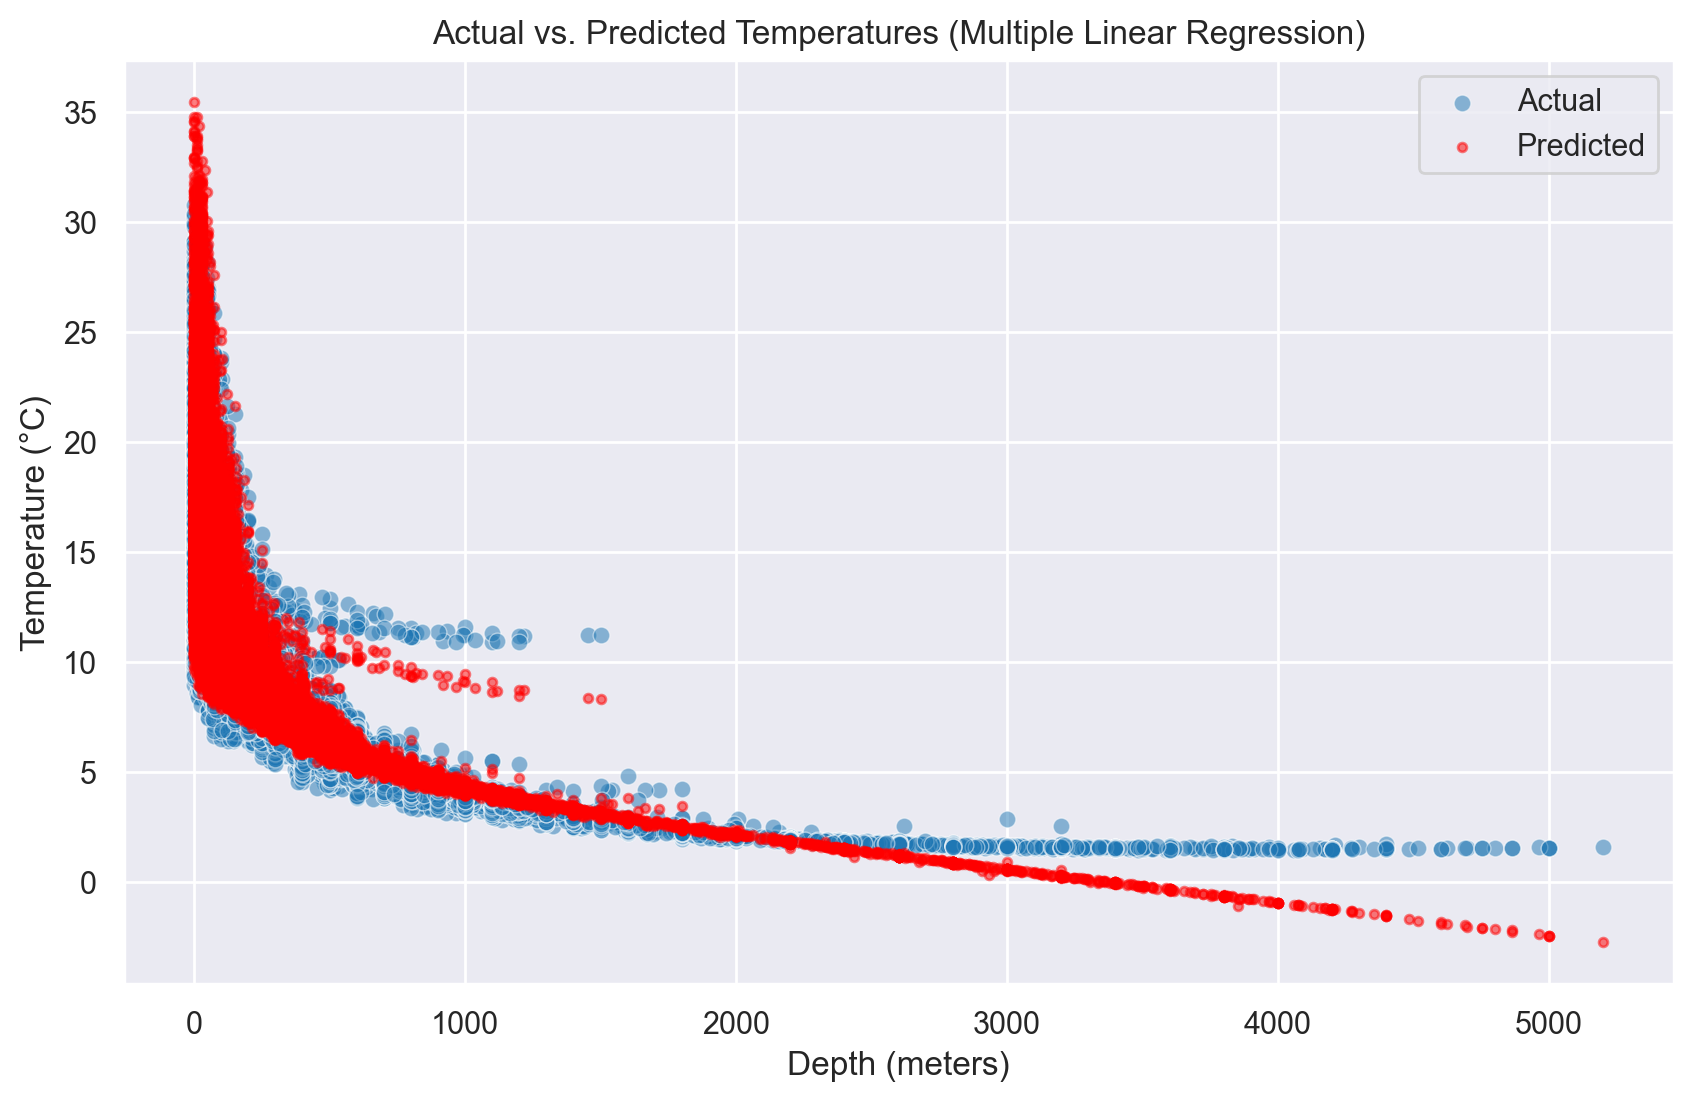

In [19]:
# Select the features (Depthm) and the target (T_degC)
X_all = bottle_df[["Depthm","Cst_Cnt", "Salnty","O2ml_L", "STheta"]]
y_all = bottle_df['T_degC']
#print(X_all)

# Split the data into training and test sets
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Create and train the model
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train_all, y_train_all)

# Predict the temperature for the test set
y_pred_all = model_LinearRegression.predict(X_test_all)

# Evaluate the model with the chosen metrics
RMSE_score_all_Linear_Regression = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
R2_score_all_Linear_Regression = r2_score(y_test_all, y_pred_all)

# Print the evaluation metrics
print(f"RMSE_LR_All_Features: {RMSE_score_all_Linear_Regression}")
print(f"R^2_LR_All_Features: {R2_score_all_Linear_Regression}")

# Plotting the actual test data
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=X_test_all['Depthm'], y=y_test_all, label='Actual', alpha=0.5)

# Plotting the predicted values. Since 'y_pred_all' doesn't contain the 'Depthm' information,
# we reuse 'Depthm' from 'X_test_all' to align the predicted values with their corresponding depths.
ax.scatter(x=X_test_all['Depthm'], y=y_pred_all, color="red", s=10, label='Predicted', alpha=0.5)

# Setting the plot labels and title
ax.set_xlabel("Depth (meters)")
ax.set_ylabel("Temperature (°C)")
plt.title('Actual vs. Predicted Temperatures (Multiple Linear Regression)')
plt.legend()
plt.show()

### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment (possibly with similar tables and plots as in the PCA notebook).

I remind you that, standardizing the data is substracting its mean and dividing it by its standard deviation.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Split the PCA-transformed data into training and test sets
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)
X_test_scaled = scaler.fit_transform(X_test_all)


# Apply PCA, assuming we want to keep 5 principal components
pca = PCA(n_components=5)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Create and train the regression model on the PCA-transformed training data
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_all)


# Predict the temperature for the PCA-transformed test set
y_pred_pca = model_pca.predict(X_test_pca)


# Evaluate the model with the chosen metrics on the PCA-transformed test data
RMSE_score_pca = np.sqrt(mean_squared_error(y_test_all, y_pred_pca))
R2_score_pca = r2_score(y_test_all, y_pred_pca)


# Print the evaluation metrics
print(f"RMSE (PCA features): {RMSE_score_pca}")
print(f"R^2 (PCA features): {R2_score_pca}\n")

# Analyze the PCA components
print("PCA Components (each row corresponds to a principal component):")
print(pca.components_)


print("\nExplained variance ratio (importance of each component):")
print(pca.explained_variance_ratio_)

# To compare, you might want to fit and evaluate a regression model on the non-PCA-transformed data
# and then compare the performance metrics (RMSE and R^2) and possibly the coefficients
# if you are interested in feature importance.


pc_names = [f"PC{i+1}" for i in range(pca.n_components_)]
pca_expl_vars = pd.Series(pca.explained_variance_ratio_, index=pc_names)

with pd.option_context("display.float_format", "{:.2%}".format):
    display(pca_expl_vars)

RMSE (PCA features): 0.3332695369364601
R^2 (PCA features): 0.9937650274585313

PCA Components (each row corresponds to a principal component):
[[ 0.43844327 -0.14897098  0.49366853 -0.52560435  0.51537035]
 [-0.02371299 -0.98016961  0.01490824  0.11944403 -0.1556152 ]
 [ 0.86647793  0.01939589 -0.37472716  0.32693371 -0.03916251]
 [ 0.20273961  0.1290235   0.72248951  0.20964719 -0.6134383 ]
 [-0.1237653   0.00720483  0.30603528  0.74741929  0.57648682]]

Explained variance ratio (importance of each component):
[0.63596019 0.19246435 0.10000899 0.05654985 0.01501661]


PC1   63.60%
PC2   19.25%
PC3   10.00%
PC4    5.65%
PC5    1.50%
dtype: float64

The results we obtained correspond to the application of PCA (Principal Component Analysis) to the data. Here is an interpretation of the specific results:

1. **PCA Components (Principal Components)**: This matrix shows the principal components resulting from PCA. Each row represents a principal component, and each column represents one of the original variables. The values in the matrix indicate how the original variables are combined to create each principal component. For example, the first principal component (PC1) is a linear combination of all the original variables, and its coefficients are given by the first row of this matrix.

2. **Explained Variance Ratio**: This list of values shows the proportion of the total variance in the data explained by each of the principal components. For example, PC1 explains approximately 63.60% of the total variance in the data, PC2 explains 19.25%, and so on. These values are important because they indicate how much information is retained when retaining each component. In this case, it appears that the first principal components (PC1 and PC2) explain the majority of the variance in the data.

3. **Percentage of Explained Variance**: Alongside the list of explained variance ratios, the corresponding percentage is provided. For example, PC1 explains 63.60% of the total variance in the data. This is useful for understanding how much the dimensionality of the data has been reduced when retaining certain components. In this case, the first two components (PC1 and PC2) explain over 80% of the total variance, suggesting that you might consider retaining only these two components if you want a more compact representation of your data.

In summary, these PCA results indicate how the original variables are combined to form principal components, how much variance those components explain, and the relative importance of each component in representing your data. You can use this information to make decisions about how many principal components you want to retain and how to use them in subsequent analyses or in predicting your sixth variable.